In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/R_8998.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/battery90.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/metal427.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/R_9028.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/R_8999.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/battery526.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/white-glass218.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/R_8972.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/white-glass76.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/TRAIN.1_NBIODEG_CCW_3668.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/TRAIN.1_NBIODEG_CCW_3663.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/green-glass151.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/white-glass360.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/white-glass772.jpg
/kaggle/input/recyclenonrecyclev2/DATASET/TEST/N/white-glass761.jpg
/kaggle/

# install TensorFlow 2.8, kalau error lewati saja.

In [3]:
!pip install -U tensorflow==2.8.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.8.0-alpha0 (from versions: none)
ERROR: No matching distribution found for tensorflow==2.8.0-alpha0


# Import Library

In [4]:
import os
import zipfile
from tqdm import tqdm
import shutil
import time
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

# Check Data and devide

In [6]:
base_dir = '../input/recyclenonrecyclev2/DATASET'

train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

# Directory with our training recyclable and non recyclable pictures
train_non_dir = os.path.join(train_dir, 'N')
train_recycle_dir = os.path.join(train_dir, 'R')

# Directory with our validation recyclable and non recyclable pictures
validation_non_dir = os.path.join(validation_dir, 'N')
validation_recycle_dir = os.path.join(validation_dir, 'R')

In [7]:
train_non_fnames = os.listdir( train_non_dir )
train_recycle_fnames = os.listdir( train_recycle_dir )

print(train_non_fnames[:10])
print(train_recycle_fnames[:10])

['R_6214.jpg', 'brown-glass577.jpg', 'R_5469.jpg', 'trash625.jpg', 'brown-glass13.jpg', 'TRAIN.3_NBIODEG_ORI_3399.jpg', 'TRAIN.3_NBIODEG_ORI_2244.jpg', 'battery161.jpg', 'TRAIN.4_NBIODEG_CCW_650.jpg', 'trash497.jpg']
['O_5670.jpg', 'O_1764.jpg', 'R_8141.jpg', 'O_9501.jpg', 'O_364.jpg', 'O_5301.jpg', 'R_2463.jpg', 'O_2993.jpg', 'O_7252.jpg', 'O_5410.jpg']


In [8]:
print('total training Non-Recyclable images :', len(os.listdir(train_non_dir)))
print('total training Recyclable images :', len(os.listdir(train_recycle_dir)))

print('total validation Non-Recyclable images :', len(os.listdir(validation_non_dir)))
print('total validation Recyclable images :', len(os.listdir(validation_recycle_dir)))

total training Non-Recyclable images : 8740
total training Recyclable images : 20852
total validation Non-Recyclable images : 804
total validation Recyclable images : 2171


# Visualize Data

In [9]:
train_path = "../input/recyclenonrecyclev2/DATASET/TRAIN/"
test_path = "../input/recyclenonrecyclev2/DATASET/TEST/"

In [10]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

100%|██████████| 20852/20852 [01:25<00:00, 242.56it/s]


In [11]:
data.shape

(29592, 2)

In [12]:
from collections import Counter
Counter(y_data)

Counter({'N': 8740, 'R': 20852})

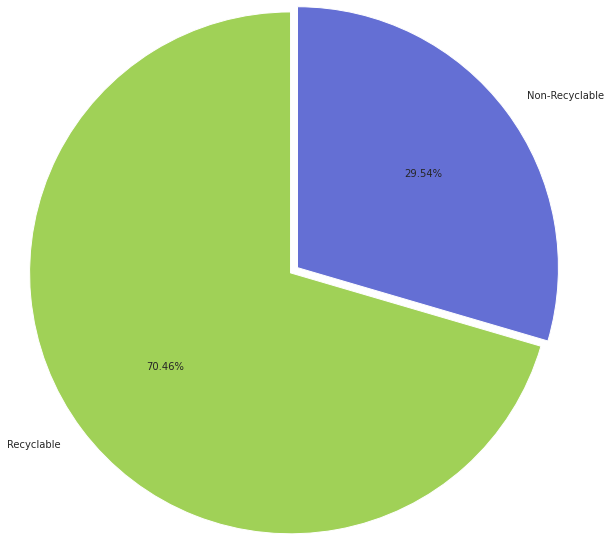

In [13]:
colors = ['#a0d157','#646fd4']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Recyclable','Non-Recyclable'], colors= colors,radius=3)
plt.show()

# Callbacks

In [14]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.79: 
                print("\nReached 76% val_accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

# Training and Validation Generator

In [29]:
def train_val_generators(train_dir, validation_dir):
  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range=40,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=150,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=150,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  
  return train_generator, validation_generator


In [30]:
# Test generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 29592 images belonging to 2 classes.
Found 2975 images belonging to 2 classes.


# Model Layer

In [31]:
def create_model():
  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
  

  return model

# Training Model

In [34]:
from gc import callbacks
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    callbacks=[callbacks],
                    validation_data=validation_generator)

2022-05-30 02:26:19.072338: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
198/198 [==============================] - 615s 3s/step - loss: 0.6139 - accuracy: 0.7138 - val_loss: 0.4019 - val_accuracy: 0.8161
Epoch 2/20
198/198 [==============================] - 612s 3s/step - loss: 0.4954 - accuracy: 0.7402 - val_loss: 0.3732 - val_accuracy: 0.8212
Epoch 3/20
198/198 [==============================] - 610s 3s/step - loss: 0.4867 - accuracy: 0.7421 - val_loss: 0.3854 - val_accuracy: 0.8007
Epoch 4/20
198/198 [==============================] - 609s 3s/step - loss: 0.4725 - accuracy: 0.7510 - val_loss: 0.3679 - val_accuracy: 0.8309
Epoch 5/20
198/198 [==============================] - 609s 3s/step - loss: 0.4684 - accuracy: 0.7517 - val_loss: 0.3665 - val_accuracy: 0.8215
Epoch 6/20
198/198 [==============================] - 608s 3s/step - loss: 0.4605 - accuracy: 0.7598 - val_loss: 0.3631 - val_accuracy: 0.8299
Epoch 7/20
198/198 [==============================] - 606s 3s/step - loss: 0.4529 - accuracy: 0.7703 - val_loss: 0.3811 - val_accuracy: 0.8134

# Graph Result

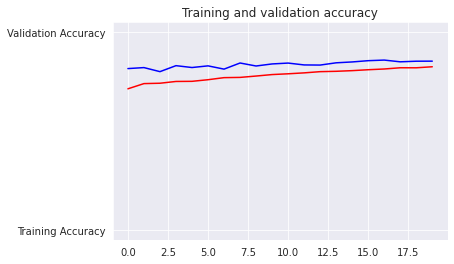

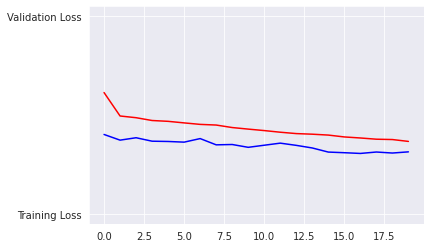

In [35]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

# Save Model

In [39]:
model.save('saved_model/my_model')

# Model Convert 

In [40]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model/my_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('RnRv2model.tflite', 'wb') as f:
  f.write(tflite_model)

2022-05-30 06:17:26.368884: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-05-30 06:17:26.368959: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2022-05-30 06:17:26.368970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2022-05-30 06:17:26.370823: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: saved_model/my_model
2022-05-30 06:17:26.377735: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2022-05-30 06:17:26.377799: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_model/my_model
2022-05-30 06:17:26.379206: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-30 06:17:26.389279: I tensor